## Imports

In [2]:
# Import required libraries
import os
import gc
import sys
import json
import random
from pathlib import Path
import math

import re
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io



import cv2 # CV2 for image manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm

from imgaug import augmenters as iaa

import seaborn as sns
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold, KFold

## Required packages

In [3]:
# ! conda activate tf1
#!/bin/bash
# ! conda env list
# !pip install tensorflow==1.15.0
# !pip install keras==2.1.5 --upgrade
# # !pip install keras==2.1.0 --upgrade



import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

1.15.0
2.1.5


Using TensorFlow backend.


In [4]:
!ls


'iMaterialist c-2020.ipynb'		       requirements.txt
'iMaterialist c-2020-level-attributes.ipynb'   sample_submission.csv
 imaterialist-fashion-2020-fgvc7.zip	       submission.csv
 kaggle-imaterialist			       test
 label_descriptions.json		       train
 Mask_RCNN				       train.csv
 mask_rcnn_coco.h5


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
     # Restrict TensorFlow to only use the first GPU
     try:
         # Currently, memory growth needs to be the same across GPUs
         for gpu in gpus:
             tf.config.experimental.set_memory_growth(gpu, True)
#          tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
     except RuntimeError as e:
         # Visible devices must be set before GPUs have been initialized
         print(e)

2 Physical GPUs, 2 Logical GPU


## Competation and local paths, variables

In [6]:
# local Notebook
label_description_path=r'/root/kaggle/label_descriptions.json'
sample_submission_path=r'/root/kaggle/sample_submission.csv'
train_path='/root/kaggle/train.csv'
COCO_WEIGHTS_PATH='/root/kaggle/Mask_RCNN/mask_rcnn_coco.h5'
DATA_DIR = Path('/root/kaggle/')
ROOT_DIR = os.path.abspath("/root/kaggle/Mask_RCNN/")
ROOT_DIR2 = os.path.abspath("/root/kaggle/Mask_RCNN/")
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0


# # competation Notebook
# label_description_path='/kaggle/input/imaterialist-fashion-2020-fgvc7/label_descriptions.json'
# sample_submission_path='/kaggle/input/imaterialist-fashion-2020-fgvc7/sample_submission.csv'
# train_path='/kaggle/input/imaterialist-fashion-2020-fgvc7/train.csv'
# COCO_WEIGHTS_PATH='mask_rcnn_coco.h5'
# DATA_DIR = Path('/kaggle/input/imaterialist-fashion-2020-fgvc7')
# ROOT_DIR = os.path.abspath("/kaggle/working/Mask_RCNN/")
# ROOT_DIR2 = os.path.abspath("/kaggle/working/Mask_RCNN/")


In [7]:
!ls

'iMaterialist c-2020.ipynb'		       requirements.txt
'iMaterialist c-2020-level-attributes.ipynb'   sample_submission.csv
 imaterialist-fashion-2020-fgvc7.zip	       submission.csv
 kaggle-imaterialist			       test
 label_descriptions.json		       train
 Mask_RCNN				       train.csv
 mask_rcnn_coco.h5


## Require Downloads

In [8]:
# !git clone https://www.github.com/matterport/Mask_RCNN.git
# !git clone https://github.com/matterport/Mask_RCNN.git
# os.chdir('Mask_RCNN')

# !rm -rf .git
# !rm -rf images assets
# 
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
# !ls -lh mask_rcnn_coco.h5

sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.append(ROOT_DIR2)
sys.path.append(os.path.abspath("../"))


# !cd ../

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## label description

In [9]:
%%time
with open(label_description_path, 'r') as file:
    label_desc = json.load(file)

CPU times: user 1.93 ms, sys: 552 µs, total: 2.48 ms
Wall time: 1.76 ms


In [10]:
# label_desc

## Submition file

In [11]:
sample_sub_df = pd.read_csv(sample_submission_path)

In [12]:
sample_sub_df.head()
sample_sub_df.tail()


ImageId EncodedPixels  ClassId AttributesIds
3195  ff723aa44c55277951e563c31e832731           1 1        0       111,137
3196  ff96236baf045f315c1587155c87b0dd           1 1        0       111,137
3197  ffd8c036ec503e5e5372f2e2b0f84a82           1 1        0       111,137
3198  ffebe7df5bfb5974878870b8cb3ebed4           1 1        0       111,137
3199  fffea54b50ac7e4bf24688c8614a5f27           1 1        0       111,137

## Traning File

In [13]:
%%time
train_df = pd.read_csv(train_path)

CPU times: user 11.7 s, sys: 1.31 s, total: 13 s
Wall time: 15.7 s


In [14]:
train_df.head(20)
# train_df

ImageId  \
0   00000663ed1ff0c4e0132b9b9ac53f6e   
1   00000663ed1ff0c4e0132b9b9ac53f6e   
2   00000663ed1ff0c4e0132b9b9ac53f6e   
3   00000663ed1ff0c4e0132b9b9ac53f6e   
4   00000663ed1ff0c4e0132b9b9ac53f6e   
5   00000663ed1ff0c4e0132b9b9ac53f6e   
6   00000663ed1ff0c4e0132b9b9ac53f6e   
7   00000663ed1ff0c4e0132b9b9ac53f6e   
8   00000663ed1ff0c4e0132b9b9ac53f6e   
9   0000fe7c9191fba733c8a69cfaf962b7   
10  0000fe7c9191fba733c8a69cfaf962b7   
11  0002ec21ddb8477e98b2cbb87ea2e269   
12  0002ec21ddb8477e98b2cbb87ea2e269   
13  0002ec21ddb8477e98b2cbb87ea2e269   
14  0002ec21ddb8477e98b2cbb87ea2e269   
15  0002f5a0ebc162ecfb73e2c91e3b8f62   
16  0002f5a0ebc162ecfb73e2c91e3b8f62   
17  0002f5a0ebc162ecfb73e2c91e3b8f62   
18  0004467156e47b0eb6de4aa6479cbd15   
19  0004467156e47b0eb6de4aa6479cbd15   

                                        EncodedPixels  Height  Width  ClassId  \
0   6068157 7 6073371 20 6078584 34 6083797 48 608...    5214   3676        6   
1   6323163 11 6328356 32 6333549 53 6338742 75 63...    5214   3676        0   
2   8521389 10 8526585 30 8531789 42 8537002 46 85...    5214   3676       28   
3   12903854 2 12909064 7 12914275 10 12919485 15 ...    5214   3676       31   
4   10837337 5 10842542 14 10847746 24 10852951 33...    5214   3676       32   
5   11464158 10 11469372 30 11474586 43 11479800 4...    5214   3676       32   
6   5910568 31 5915775 65 5920982 69 5926189 73 59...    5214   3676       31   
7   6421446 292 6426657 298 6431867 305 6437078 31...    5214   3676       29   
8   4566382 8 4571592 25 4576803 41 4582013 58 458...    5214   3676        4   
9   2201176 1 2203623 3 2206071 5 2208518 8 221096...    2448   2448       33   
10  1343707 9 1346138 27 1348569 44 1351000 62 135...    2448   2448        1   
11  2673735 2 2676734 8 2679734 13 2682733 19 2685...    3000   1997       33   
12  2287509 4 2290504 12 2290588 26 2293501 18 229...    3000   1997       10   
13  3077799 43 3080792 52 3083786 60 3086779 70 30...    3000   1997       23   
14  2678617 8 2681610 18 2684607 25 2687605 31 269...    3000   1997       23   
15  435 132 1002 132 1569 132 2136 132 2703 132 32...     567    400       10   
16  107288 1 107854 3 108421 2 108987 3 109554 2 1...     567    400       33   
17  133262 2 133826 4 134390 6 134956 7 135522 7 1...     567    400       15   
18  132663 8 133396 25 134130 41 134868 53 135611 ...     750    500       10   
19  186967 3 187712 9 188457 15 189202 22 189950 2...     750    500       33   

                          AttributesIds  
0       115,136,143,154,230,295,316,317  
1       115,136,142,146,225,295,316,317  
2                                   163  
3                               160,204  
4                                   219  
5                                   219  
6                               160,204  
7                                   174  
8    17,115,136,145,149,225,295,311,317  
9                                   190  
10            0,115,145,146,295,316,317  
11                                  182  
12      102,128,142,150,229,295,301,318  
13                                  NaN  
14                                  NaN  
15  108,115,119,141,155,229,286,316,317  
16                                  187  
17                                  NaN  
18              115,141,155,295,305,317  
19                                  188

In [15]:
print(f'Shape of training dataset: {train_df.shape}')
print(f'Num of images in training set: {train_df["ImageId"].nunique()}')

Shape of training dataset: (333401, 6)
Num of images in training set: 45623


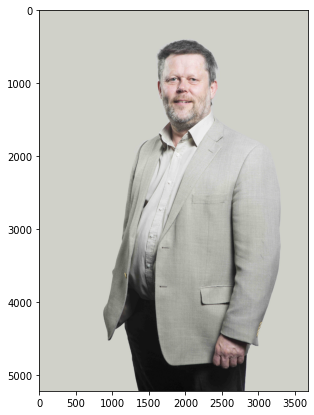

In [16]:
plt.figure(figsize = (70,7))
# min_height = list(set(train_df[train_df['Height'] == train_df['Height'].min()]['ImageId']))[0]
img_id='00000663ed1ff0c4e0132b9b9ac53f6e'
plt.imshow(mpimg.imread(f'{DATA_DIR}/train/{img_id}.jpg'))
plt.grid(False)
plt.show()

In [17]:
num_classes = len(label_desc['categories'])
num_attributes = len(label_desc['attributes'])
print(f'Total # of classes: {num_classes}')
print(f'Total # of attributes: {num_attributes}')

Total # of classes: 46
Total # of attributes: 294


In [18]:
categories_df = pd.DataFrame(label_desc['categories'])
attributes_df = pd.DataFrame(label_desc['attributes'])
categories_df

id                                     name   supercategory  level
0    0                            shirt, blouse       upperbody      2
1    1                 top, t-shirt, sweatshirt       upperbody      2
2    2                                  sweater       upperbody      2
3    3                                 cardigan       upperbody      2
4    4                                   jacket       upperbody      2
5    5                                     vest       upperbody      2
6    6                                    pants       lowerbody      2
7    7                                   shorts       lowerbody      2
8    8                                    skirt       lowerbody      2
9    9                                     coat       wholebody      2
10  10                                    dress       wholebody      2
11  11                                 jumpsuit       wholebody      2
12  12                                     cape       wholebody      2
13  13                                  glasses            head      2
14  14                                      hat            head      2
15  15  headband, head covering, hair accessory            head      2
16  16                                      tie            neck      2
17  17                                    glove  arms and hands      2
18  18                                    watch  arms and hands      2
19  19                                     belt           waist      2
20  20                               leg warmer   legs and feet      2
21  21                        tights, stockings   legs and feet      2
22  22                                     sock   legs and feet      2
23  23                                     shoe   legs and feet      2
24  24                              bag, wallet          others      2
25  25                                    scarf          others      2
26  26                                 umbrella          others      2
27  27                                     hood   garment parts      2
28  28                                   collar   garment parts      2
29  29                                    lapel   garment parts      2
30  30                                epaulette   garment parts      2
31  31                                   sleeve   garment parts      2
32  32                                   pocket   garment parts      2
33  33                                 neckline   garment parts      2
34  34                                   buckle        closures      2
35  35                                   zipper        closures      2
36  36                                 applique     decorations      2
37  37                                     bead     decorations      2
38  38                                      bow     decorations      2
39  39                                   flower     decorations      2
40  40                                   fringe     decorations      2
41  41                                   ribbon     decorations      2
42  42                                    rivet     decorations      2
43  43                                   ruffle     decorations      2
44  44                                   sequin     decorations      2
45  45                                   tassel     decorations      2

In [19]:
pd.set_option('display.max_rows', 300)
attributes_df

id                                name  \
0      0                   classic (t-shirt)   
1      1                        polo (shirt)   
2      2                          undershirt   
3      3                      henley (shirt)   
4      4                    ringer (t-shirt)   
5      5                    raglan (t-shirt)   
6      6                       rugby (shirt)   
7      7                      sailor (shirt)   
8      8                          crop (top)   
9      9                        halter (top)   
10    10                            camisole   
11    11                          tank (top)   
12    12                       peasant (top)   
13    13                          tube (top)   
14    14                         tunic (top)   
15    15                         smock (top)   
16    16                              hoodie   
17    17                              blazer   
18    18                        pea (jacket)   
19    19                     puffer (jacket)   
20    20                      biker (jacket)   
21    21                    trucker (jacket)   
22    22                     bomber (jacket)   
23    23                              anorak   
24    24                     safari (jacket)   
25    25                        mao (jacket)   
26    26                      nehru (jacket)   
27    27                    norfolk (jacket)   
28    28           classic military (jacket)   
29    29                      track (jacket)   
30    30                         windbreaker   
31    31                     chanel (jacket)   
32    32                              bolero   
33    33                     tuxedo (jacket)   
34    34                    varsity (jacket)   
35    35                       crop (jacket)   
36    36                               jeans   
37    37                          sweatpants   
38    38                            leggings   
39    39                 hip-huggers (pants)   
40    40                       cargo (pants)   
41    41                            culottes   
42    42                       capri (pants)   
43    43                       harem (pants)   
44    44                      sailor (pants)   
45    45                             jodhpur   
46    46                         peg (pants)   
47    47                        camo (pants)   
48    48                       track (pants)   
49    49                        crop (pants)   
50    50                      short (shorts)   
51    51                      booty (shorts)   
52    52                    bermuda (shorts)   
53    53                      cargo (shorts)   
54    54                              trunks   
55    55                         boardshorts   
56    56                               skort   
57    57                    roll-up (shorts)   
58    58                     tie-up (shorts)   
59    59                    culotte (shorts)   
60    60                     lounge (shorts)   
61    61                            bloomers   
62    62                        tutu (skirt)   
63    63                                kilt   
64    64                        wrap (skirt)   
65    65                      skater (skirt)   
66    66                       cargo (skirt)   
67    67                      hobble (skirt)   
68    68                      sheath (skirt)   
69    69                   ball gown (skirt)   
70    70                       gypsy (skirt)   
71    71                     rah-rah (skirt)   
72    72                     prairie (skirt)   
73    73                    flamenco (skirt)   
74    74                   accordion (skirt)   
75    75                      sarong (skirt)   
76    76                       tulip (skirt)   
77    77                      dirndl (skirt)   
78    78                       godet (skirt)   
79    79                      blanket (coat)   
80    80                               parka   
81    81                       trench (coat)   
82    82              

In [20]:
def create_mask(size):
    image_ids = train_df['ImageId'].unique()[size:size+size]
    images_meta=[]

    for image_id in image_ids:
        img = mpimg.imread(f'{DATA_DIR}/train/{image_id}.jpg')
#         print(img)
        images_meta.append({
            'image': img,
            'shape': img.shape,
            'encoded_pixels': train_df[train_df['ImageId'] == image_id]['EncodedPixels'],
            'class_ids':  train_df[train_df['ImageId'] == image_id]['ClassId']
        })

    masks = []
    for image in images_meta:
        shape = image.get('shape')
        encoded_pixels = list(image.get('encoded_pixels'))
        class_ids = list(image.get('class_ids'))
        
        # Initialize numpy array with shape same as image size
        height, width = shape[:2]
        mask = np.zeros((height, width)).reshape(-1)
        
        # Iterate over encoded pixels and create mask
        for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            splitted_pixels = list(map(int, pixel_str.split()))
            pixel_starts = splitted_pixels[::2]
            run_lengths = splitted_pixels[1::2]
            assert max(pixel_starts) < mask.shape[0]
            for pixel_start, run_length in zip(pixel_starts, run_lengths):
                pixel_start = int(pixel_start) - 1
                run_length = int(run_length)
                mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4
        masks.append(mask.reshape((height, width), order='F'))  # https://stackoverflow.com/questions/45973722/how-does-numpy-reshape-with-order-f-work
    return masks, images_meta

In [21]:
def plot_segmented_images(size=6, figsize=(14, 14)):
    # First create masks from given segments
    masks, images_meta = create_mask(size)
    
    # Plot images in groups of 4 images
    n_groups = 4
    
    count = 0
    for index in range(size // 4):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        for row in ax:
            for col in row:
                col.imshow(images_meta[count]['image'])
                col.imshow(masks[count], alpha=0.75)
                col.axis('off')
                count += 1
        plt.show()
    gc.collect()

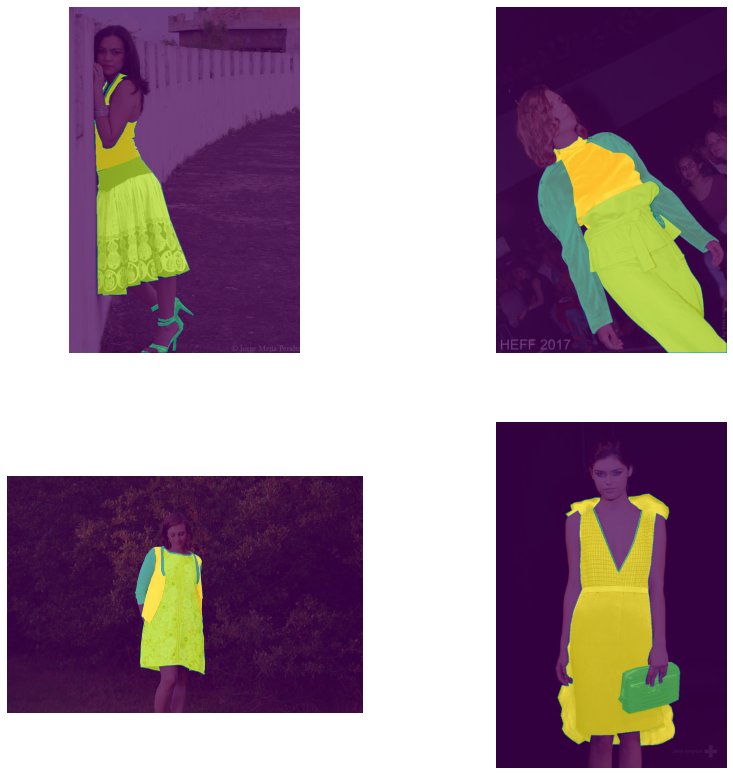

In [22]:
plot_segmented_images()

## Data Prepration for class only

In [23]:
train_df = train_df.drop('AttributesIds', axis=1)

In [24]:
train_df.head(10)

ImageId  \
0  00000663ed1ff0c4e0132b9b9ac53f6e   
1  00000663ed1ff0c4e0132b9b9ac53f6e   
2  00000663ed1ff0c4e0132b9b9ac53f6e   
3  00000663ed1ff0c4e0132b9b9ac53f6e   
4  00000663ed1ff0c4e0132b9b9ac53f6e   
5  00000663ed1ff0c4e0132b9b9ac53f6e   
6  00000663ed1ff0c4e0132b9b9ac53f6e   
7  00000663ed1ff0c4e0132b9b9ac53f6e   
8  00000663ed1ff0c4e0132b9b9ac53f6e   
9  0000fe7c9191fba733c8a69cfaf962b7   

                                       EncodedPixels  Height  Width  ClassId  
0  6068157 7 6073371 20 6078584 34 6083797 48 608...    5214   3676        6  
1  6323163 11 6328356 32 6333549 53 6338742 75 63...    5214   3676        0  
2  8521389 10 8526585 30 8531789 42 8537002 46 85...    5214   3676       28  
3  12903854 2 12909064 7 12914275 10 12919485 15 ...    5214   3676       31  
4  10837337 5 10842542 14 10847746 24 10852951 33...    5214   3676       32  
5  11464158 10 11469372 30 11474586 43 11479800 4...    5214   3676       32  
6  5910568 31 5915775 65 5920982 69 5926189 73 59...    5214   3676       31  
7  6421446 292 6426657 298 6431867 305 6437078 31...    5214   3676       29  
8  4566382 8 4571592 25 4576803 41 4582013 58 458...    5214   3676        4  
9  2201176 1 2203623 3 2206071 5 2208518 8 221096...    2448   2448       33

In [25]:
image_df = train_df.groupby('ImageId')['EncodedPixels', 'ClassId'].agg(lambda x: list(x))
size_df = train_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')
print("Total images: ", len(image_df))
image_df.head(10)

/root/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Total images:  45623


/root/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


EncodedPixels  \
ImageId                                                                               
00000663ed1ff0c4e0132b9b9ac53f6e  [6068157 7 6073371 20 6078584 34 6083797 48 60...   
0000fe7c9191fba733c8a69cfaf962b7  [2201176 1 2203623 3 2206071 5 2208518 8 22109...   
0002ec21ddb8477e98b2cbb87ea2e269  [2673735 2 2676734 8 2679734 13 2682733 19 268...   
0002f5a0ebc162ecfb73e2c91e3b8f62  [435 132 1002 132 1569 132 2136 132 2703 132 3...   
0004467156e47b0eb6de4aa6479cbd15  [132663 8 133396 25 134130 41 134868 53 135611...   
00048c3a2fb9c29340473c4cfc06424a  [239016 3 239989 6 240963 7 241938 8 242913 9 ...   
0006ea84499fd9a06fefbdf47a5eb4c0  [73327 6 74328 18 75330 37 76335 63 77340 88 7...   
000775b6b5e27b011dc8bba2d7b85211  [426259 9 427858 12 429457 14 431056 17 432655...   
000aac3870ea7c59ca0333ffa5327323  [8971124 17 8975101 49 8979077 82 8983053 116 ...   
000b3a87508b0fa185fbd53ecbe2e4c6  [291578 3 292856 8 294133 13 295410 19 296687 ...   

                                                            ClassId  Height  \
ImageId                                                                       
00000663ed1ff0c4e0132b9b9ac53f6e  [6, 0, 28, 31, 32, 32, 31, 29, 4]    5214   
0000fe7c9191fba733c8a69cfaf962b7                            [33, 1]    2448   
0002ec21ddb8477e98b2cbb87ea2e269                   [33, 10, 23, 23]    3000   
0002f5a0ebc162ecfb73e2c91e3b8f62                       [10, 33, 15]     567   
0004467156e47b0eb6de4aa6479cbd15               [10, 33, 31, 31, 15]     750   
00048c3a2fb9c29340473c4cfc06424a     [13, 1, 33, 8, 35, 24, 23, 23]     975   
0006ea84499fd9a06fefbdf47a5eb4c0                 [1, 33, 8, 23, 23]    1000   
000775b6b5e27b011dc8bba2d7b85211             [33, 1, 19, 6, 31, 31]    1600   
000aac3870ea7c59ca0333ffa5327323            [10, 33, 3, 31, 31, 33]    4000   
000b3a87508b0fa185fbd53ecbe2e4c6                       [10, 33, 24]    1280   

                                  Width  
ImageId                                  
00000663ed1ff0c4e0132b9b9ac53f6e   3676  
0000fe7c9191fba733c8a69cfaf962b7   2448  
0002ec21ddb8477e98b2cbb87ea2e269   1997  
0002f5a0ebc162ecfb73e2c91e3b8f62    400  
0004467156e47b0eb6de4aa6479cbd15    500  
00048c3a2fb9c29340473c4cfc06424a    650  
0006ea84499fd9a06fefbdf47a5eb4c0    667  
000775b6b5e27b011dc8bba2d7b85211   1067  
000aac3870ea7c59ca0333ffa5327323   6000  
000b3a87508b0fa185fbd53ecbe2e4c6    852

In [26]:
image_df['EncodedPixels'][0]

['6068157 7 6073371 20 6078584 34 6083797 48 6089010 62 6094223 72 6099436 76 6104649 80 6109862 85 6115075 89 6120288 93 6125501 98 6130714 102 6135927 106 6141140 111 6146354 114 6151567 118 6156780 123 6161993 127 6167206 131 6172419 136 6177632 140 6182845 144 6188058 149 6193271 153 6198484 157 6203697 162 6208910 166 6214124 169 6219337 174 6224550 178 6229763 182 6234976 187 6240189 191 6245402 195 6250615 200 6255828 204 6261041 208 6266254 213 6271467 218 6276680 224 6281893 229 6287107 233 6292320 238 6297533 244 6302746 249 6307959 254 6313172 259 6318385 265 6323598 270 6328811 275 6334024 280 6339237 286 6344450 291 6349663 296 6354877 300 6360090 306 6365303 311 6370516 316 6375729 322 6380942 327 6386155 332 6391368 337 6396581 343 6401794 348 6407007 353 6412220 358 6417433 364 6422647 368 6427860 373 6433073 378 6438286 384 6443499 389 6448712 394 6453925 399 6459138 405 6464351 410 6469564 415 6474777 420 6479990 426 6485203 431 6490416 436 6495630 441 6500843 446 650

In [27]:
!ls Mask_RCNN/

fashion20200607T0300  fashion20200607T0611  README.md
fashion20200607T0306  fashion20200607T0619  requirements.txt
fashion20200607T0311  LICENSE		    samples
fashion20200607T0316  MANIFEST.in	    setup.cfg
fashion20200607T0531  mask_rcnn_coco.h5     setup.py
fashion20200607T0542  mask_rcnn_fashion.h5  submission.csv
fashion20200607T0547  mrcnn


In [28]:
image_df.head()

EncodedPixels  \
ImageId                                                                               
00000663ed1ff0c4e0132b9b9ac53f6e  [6068157 7 6073371 20 6078584 34 6083797 48 60...   
0000fe7c9191fba733c8a69cfaf962b7  [2201176 1 2203623 3 2206071 5 2208518 8 22109...   
0002ec21ddb8477e98b2cbb87ea2e269  [2673735 2 2676734 8 2679734 13 2682733 19 268...   
0002f5a0ebc162ecfb73e2c91e3b8f62  [435 132 1002 132 1569 132 2136 132 2703 132 3...   
0004467156e47b0eb6de4aa6479cbd15  [132663 8 133396 25 134130 41 134868 53 135611...   

                                                            ClassId  Height  \
ImageId                                                                       
00000663ed1ff0c4e0132b9b9ac53f6e  [6, 0, 28, 31, 32, 32, 31, 29, 4]    5214   
0000fe7c9191fba733c8a69cfaf962b7                            [33, 1]    2448   
0002ec21ddb8477e98b2cbb87ea2e269                   [33, 10, 23, 23]    3000   
0002f5a0ebc162ecfb73e2c91e3b8f62                       [10, 33, 15]     567   
0004467156e47b0eb6de4aa6479cbd15               [10, 33, 31, 31, 15]     750   

                                  Width  
ImageId                                  
00000663ed1ff0c4e0132b9b9ac53f6e   3676  
0000fe7c9191fba733c8a69cfaf962b7   2448  
0002ec21ddb8477e98b2cbb87ea2e269   1997  
0002f5a0ebc162ecfb73e2c91e3b8f62    400  
0004467156e47b0eb6de4aa6479cbd15    500

In [29]:
# Start working on RCNN Repo

In [30]:
# Root directory of the project
# ROOT_DIR = os.path.abspath("/root/Mobin_ibm/kaggle/Mask_RCNN/")
# ROOT_DIR2 = os.path.abspath("/root/Mobin_ibm/kaggle/Mask_RCNN/")

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
# sys.path.append(ROOT_DIR2)

# from mrcnn.config import Config
# from mrcnn import utils
# import mrcnn.model as modellib
# from mrcnn import visualize
# from mrcnn.model import log

# %matplotlib inline 

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# # Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# # Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

In [31]:
class My158Config(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fashion"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2  # maybe 8 is too high

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(categories_df)  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    LEARNING_RATE=0.002
    BACKBONE="resnet50"
    
    BATCH_SIZE=12
    
    TRAIN_ROIS_PER_IMAGE = 200
    
#     MAX_GT_INSTANCES = 100
    
config = My158Config()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [32]:
# IMAGE_SIZE = 256
class FashionDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    def __init__(self):
        super().__init__(self)
        
        self.IMAGE_SIZE = 256
#         self.IMAGE_SIZE = 1024
        

    def load_images(self,count,img_df):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        for row in label_desc['categories']:
#             print(row)
            self.add_class("fashion", int(row['id']),row['name'])
    
#     for i in range(count):
#             bg_color, shapes = self.random_image(height, width)
#             self.add_image("shapes", image_id=i, path=None,
#                            width=width, height=height,
#                            bg_color=bg_color, shapes=shapes)
            
        # Add images
#         for i in range(count):
        for i, row in img_df.iterrows():
#             print(i,row)
            self.add_image("fashion",
                           image_id=row.name, 
#                            path=str(DATA_DIR/'train'/row.name) + '.jpg',
                           path=f'{DATA_DIR}/train/{row.name}.jpg',
                           labels=row['ClassId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'],
                           shape=[row['Height'],row['Width']])

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
#         bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
#         image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
#         image = image * bg_color.astype(np.uint8)
#         for shape, color, dims in info['shapes']:
#             image = self.draw_shape(image, shape, dims, color)
#         return image
        return info

    def _resize_image(self, image_path):
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
            return img
        
    def load_image(self, image_id):
        return self._resize_image(self.image_info[image_id]['path'])
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [x for x in info['labels']]
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((self.IMAGE_SIZE, self.IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)




In [33]:
#Data prepration for traning Before shuflling and spliting

# fashion_data=FashionDataset()
# fashion_data.load_images(500, image_df)
# fashion_data.prepare()

# print("Image Count: {}".format(len(fashion_data.image_ids)))
# print("Class Count: {}".format(fashion_data.num_classes))

# for i, info in enumerate(fashion_data.class_info):
#     print("{:3}. {:50}".format(i, info['name']))

In [34]:
# fashion_data.class_names

In [35]:
# for i in range(6):
#     image_id = random.choice(fashion_data.image_ids)
#     image = fashion_data.load_image(image_id)
# #     print(image)
#     mask, class_ids = fashion_data.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, fashion_data.class_names, limit=4)

In [36]:
# Shaflling data 
# sufful_img_df=image_df.reindex(np.random.permutation(image_df.index))
# # sufful_img_df

# #Spliting data Train and validation
# def split_vals(a,n): return a[:n], a[n:]
# n_valid = int(len(sufful_img_df)/100*20)
# n_trn = len(sufful_img_df)-n_valid
# train_df, valid_df = split_vals(sufful_img_df, n_trn)
# print('Traning and Validation dataset shapes!')
# print(train_df.shape)
# print(valid_df.shape)

# #Data prepration for traning
# fashion_data=FashionDataset()
# fashion_data.load_images(500,train_df)
# fashion_data.prepare()


# # Data prepration for validation
# # Validation dataset
# valid_fashion_data=FashionDataset()
# valid_fashion_data.load_images(50,valid_df)
# valid_fashion_data.prepare()

In [37]:
# Split to training and validation data
from sklearn.utils import shuffle

random.seed(42)
images_data_shuffled = shuffle(image_df)
val_size = int(0.05 * len(images_data_shuffled['ClassId']))
valid_df = images_data_shuffled[:val_size]
train_df = images_data_shuffled[val_size:]

# print(len(image_data_train), len(image_data_val))
print(f'Training set: {train_df.shape} \nValidation set: {valid_df.shape}')


#Data prepration for traning
fashion_data=FashionDataset()
# fashion_data.load_images(500,train_df)
# fashion_data.prepare()


# Data prepration for validation
# Validation dataset
valid_fashion_data=FashionDataset()
valid_fashion_data.load_images(50,valid_df)
valid_fashion_data.prepare()

Training set: (43342, 4) 
Validation set: (2281, 4)


In [38]:
# Traning Dataset Visualization
# for i in range(6):
#     image_id = random.choice(fashion_data.image_ids)
#     image = fashion_data.load_image(image_id)
# #     print(image)
#     mask, class_ids = fashion_data.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, fashion_data.class_names, limit=4)

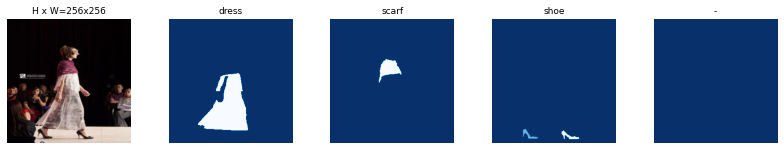

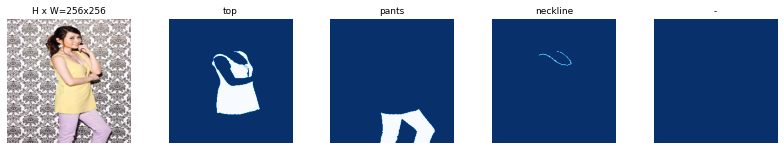

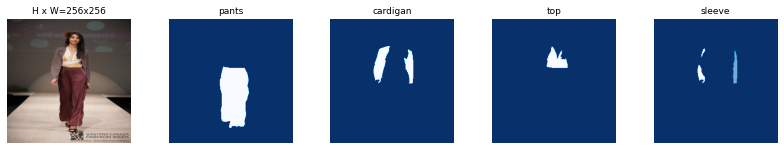

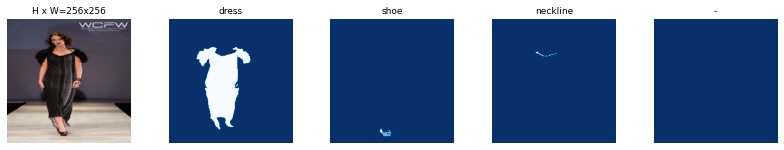

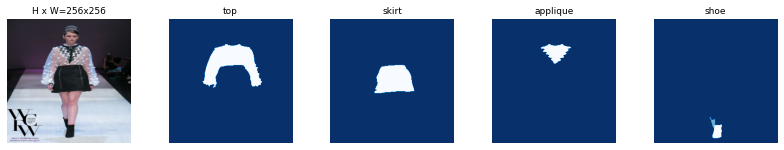

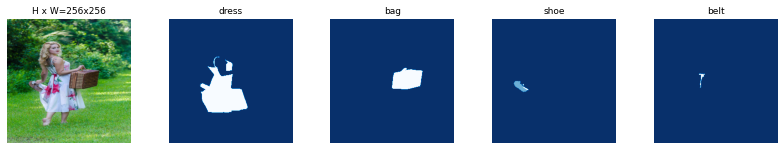

In [39]:
# Validation Dataset Visualization
for i in range(6):
    image_id = random.choice(valid_fashion_data.image_ids)
    image = valid_fashion_data.load_image(image_id)
#     print(image)
    mask, class_ids = valid_fashion_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, valid_fashion_data.class_names, limit=4)

In [40]:
# Note that any hyperparameters here, such as LR, may still not be optimal
LR = 1e-4
EPOCHS = [1, 6, 8]

import warnings 
warnings.filterwarnings("ignore")

In [41]:
DEVICE

'/gpu:0'

In [42]:
# with tf.device(DEVICE):
model = modellib.MaskRCNN(mode='training',#'',inference
                          config=config, model_dir=ROOT_DIR2)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [43]:
# COCO_WEIGHTS_PATH='/root/Mobin_ibm/kaggle/Mask_RCNN/mask_rcnn_coco.h5'


# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
# model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
#                    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                             "mrcnn_bbox", "mrcnn_mask"])#, "mrcnn_mask"

# model.load_weights(model.get_imagenet_weights(), by_name=True)

augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

## Traning

In [44]:
# train_df[20:40]
from tqdm import tqdm


In [45]:
# %%time
# with tf.device("/gpu:1"):

dataset_size=5000
for i in tqdm(range(0, len(train_df), dataset_size)):
#     all_t = []
    dataset_records = train_df[i:i + dataset_size]
#     print(dataset_records)
    fashion_data.load_images(500,dataset_records)
    fashion_data.prepare()
    model.train(fashion_data, valid_fashion_data, 
        learning_rate=config.LEARNING_RATE, 
        epochs=5, 
        layers='heads')

# model.train(fashion_data, valid_fashion_data, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=5, 
#             layers='heads')
# history = model.keras_model.history.history

  0%|          | 0/9 [00:00<?, ?it/s]


Starting at epoch 0. LR=0.002

Checkpoint Path: /root/kaggle/Mask_RCNN/fashion20200607T0624/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

 11%|█         | 1/9 [02:55<23:20, 175.03s/it]


Starting at epoch 5. LR=0.002

Checkpoint Path: /root/kaggle/Mask_RCNN/fashion20200607T0624/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

 22%|██▏       | 2/9 [03:07<14:42, 126.13s/it]


Starting at epoch 5. LR=0.002

Checkpoint Path: /root/kaggle/Mask_RCNN/fashion20200607T0624/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

 33%|███▎      | 3/9 [03:19<09:12, 92.11s/it] 


Starting at epoch 5. LR=0.002

Checkpoint Path: /root/kaggle/Mask_RCNN/fashion20200607T0624/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

 44%|████▍     | 4/9 [03:33<05:42, 68.52s/it]


Starting at epoch 5. LR=0.002

Checkpoint Path: /root/kaggle/Mask_RCNN/fashion20200607T0624/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

 56%|█████▌    | 5/9 [03:48<03:29, 52.49s/it]


Starting at epoch 5. LR=0.002

Checkpoint Path: /root/kaggle/Mask_RCNN/fashion20200607T0624/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

 67%|██████▋   | 6/9 [04:03<02:04, 41.43s/it]


Starting at epoch 5. LR=0.002

Checkpoint Path: /root/kaggle/Mask_RCNN/fashion20200607T0624/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

 78%|███████▊  | 7/9 [04:20<01:07, 33.86s/it]


Starting at epoch 5. LR=0.002

Checkpoint Path: /root/kaggle/Mask_RCNN/fashion20200607T0624/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

 89%|████████▉ | 8/9 [04:37<00:28, 28.96s/it]


Starting at epoch 5. LR=0.002

Checkpoint Path: /root/kaggle/Mask_RCNN/fashion20200607T0624/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

100%|██████████| 9/9 [04:54<00:00, 32.76s/it]


In [46]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
# model.train(fashion_data, valid_fashion_data, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=2, 
#             layers="all",
#             augmentation=augmentation)

In [47]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(ROOT_DIR2, "mask_rcnn_fashion.h5")
model.keras_model.save_weights(model_path)

In [48]:
# Load a random image from the images folder
# image = skimage.io.imread('sample.jpg')

# # original image
# plt.figure(figsize=(12,10))
# skimage.io.imshow(image)

## Detection

In [49]:
# epochs = range(EPOCHS[-1])
# plt.figure(figsize=(40,8))

# plt.subplot(141)
# plt.plot(epochs, history["loss"], label="Train loss")
# plt.plot(epochs, history["val_loss"], label="Valid loss")
# plt.legend()

# plt.subplot(142)
# plt.plot(epochs, history["mrcnn_class_loss"], label="Train class loss")
# plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class loss")
# plt.legend()

# plt.show()

# plt.figure(figsize=(40,8))

# plt.subplot(141)
# plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
# plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
# plt.legend()

# plt.subplot(142)
# plt.plot(epochs, history['mrcnn_mask_loss'], label="Train mask loss")
# plt.plot(epochs, history['val_mrcnn_mask_loss'], label="Valid mask loss")
# plt.legend()

# plt.show()

In [50]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

NameError: name 'history' is not defined

In [51]:
sample_df = sample_sub_df

In [52]:
class InferenceConfig(My158Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR2)


# assert model_path != '', "Provide path to trained weights"
# print("Loading weights from ", model_path)
# model.load_weights(model_path, by_name=True)


# model_path = os.path.join(ROOT_DIR, "mask_rcnn_fashion.h5")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /root/kaggle/Mask_RCNN/fashion20200607T0624/mask_rcnn_fashion_0005.h5
Re-starting from epoch 5


## Notebook Preferences

In [53]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax## Notebook Preferences

## Test this

original_image           shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
image_meta               shape: (59,)                 min:    0.00000  max:  419.00000  int64
gt_class_id              shape: (5,)                  min:    2.00000  max:   34.00000  int64
gt_bbox                  shape: (5, 4)                min:   68.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 5)         min:    0.00000  max:    1.00000  uint8


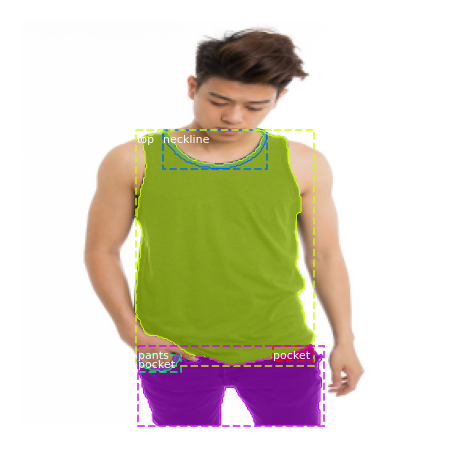

In [54]:
# Test on a random image
image_id = random.choice(valid_fashion_data.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_fashion_data, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            fashion_data.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(256, 256, 0), dtype=float64)}]

*** No instances to display *** 



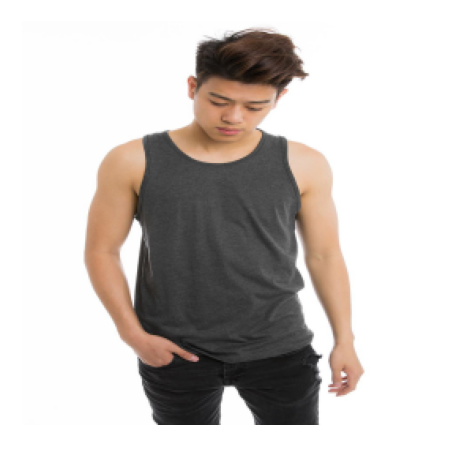

In [55]:
results = model.detect([original_image], verbose=1)
print(results)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            fashion_data.class_names, r['scores'], ax=get_ax())

# Work in progress

In [56]:
# Convert data to run-length encoding
import itertools
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [57]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [58]:
IMAGE_SIZE = 256

In [59]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [60]:
%%time
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
#     image = resize_image(str(DATA_DIR/'test'/row['ImageId']) + '.jpg')
    image = resize_image(f'{DATA_DIR}/test/{row["ImageId"]}.jpg')
    
    result = model.detect([image], verbose=1)[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
#             sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label, np.NaN])#111,137
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label, '111,137'])
            
#         print(sub_list)
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23, '111,137'])
        missing_count += 1
#         print('Misssssss')
    

  0%|          | 0/3200 [00:00<?, ?it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  253.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  149.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  0%|          | 2/3200 [00:00<12:19,  4.32it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  0%|          | 4/3200 [00:00<12:18,  4.33it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:   19.00000  max:  251.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -103.70000  max:  137.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  0%|          | 6/3200 [00:01<11:37,  4.58it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -121.70000  max:  131.30000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  0%|          | 7/3200 [00:01<12:42,  4.19it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  0%|          | 9/3200 [00:01<11:19,  4.69it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  132.20000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  132.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  0%|          | 12/3200 [00:02<08:36,  6.17it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  150.10000

  0%|          | 14/3200 [00:02<07:15,  7.31it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  1%|          | 17/3200 [00:02<07:22,  7.19it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -115.80000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000

  1%|          | 19/3200 [00:03<06:38,  7.98it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  250.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -121.70000  max:  137.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000

  1%|          | 23/3200 [00:03<05:21,  9.88it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  235.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  111.30000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  1%|          | 25/3200 [00:04<09:20,  5.66it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -120.70000  max:  140.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  133.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8


  1%|          | 26/3200 [00:04<08:28,  6.24it/s]

molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  1%|          | 27/3200 [00:04<11:49,  4.47it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  238.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -117.70000  max:  133.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000

  1%|          | 30/3200 [00:05<11:20,  4.66it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  253.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -115.70000  max:  144.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  1%|          | 33/3200 [00:05<13:27,  3.92it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000

  1%|          | 34/3200 [00:06<15:51,  3.33it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  1%|          | 35/3200 [00:06<14:24,  3.66it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  1%|          | 36/3200 [00:06<14:50,  3.55it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  227.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  123.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  131.30000

  1%|▏         | 40/3200 [00:06<09:20,  5.64it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  137.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  1%|▏         | 41/3200 [00:07<11:05,  4.75it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  1%|▏         | 43/3200 [00:07<09:50,  5.34it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -116.70000  max:  137.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  1%|▏         | 44/3200 [00:07<11:53,  4.42it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  1%|▏         | 47/3200 [00:08<08:50,  5.94it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000

  2%|▏         | 49/3200 [00:08<07:26,  7.06it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  217.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  112.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  147.10000

  2%|▏         | 53/3200 [00:08<06:19,  8.30it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  149.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  2%|▏         | 55/3200 [00:08<05:46,  9.06it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  140.10000

  2%|▏         | 57/3200 [00:09<05:26,  9.64it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  237.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  116.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  2%|▏         | 59/3200 [00:09<05:57,  8.79it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -117.70000  max:  149.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


  2%|▏         | 61/3200 [00:09<06:28,  8.08it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:  141.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  145.10000

  2%|▏         | 65/3200 [00:09<05:16,  9.90it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  132.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  146.10000

  2%|▏         | 66/3200 [00:10<08:04,  6.47it/s]


KeyboardInterrupt: 

In [61]:
sample_sub_df.columns

Index(['ImageId', 'EncodedPixels', 'ClassId', 'AttributesIds'], dtype='object')

In [62]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
submission_df.head()

Total image results:  66
Missing Images:  66


ImageId EncodedPixels  ClassId AttributesIds
0  003d41dd20f271d27219fe7ee6de727d           1 1       23       111,137
1  0046f98599f05fd7233973e430d6d04d           1 1       23       111,137
2  004e9e21cd1aca568a8ffc77a54638ce           1 1       23       111,137
3  005b37fce3c0f641d327d95dd832f51b           1 1       23       111,137
4  0094940c58c343b742f48ae26eb5e9fa           1 1       23       111,137

In [63]:
# submission = submission_df.groupby('ImageId')['EncodedPixels', 'ClassId', 'AttributesIds'].agg(lambda x: list(x))

In [64]:
submission_df.to_csv("submission.csv", index=False)
# submission.to_csv('submission.csv', index=False)


*** No instances to display *** 



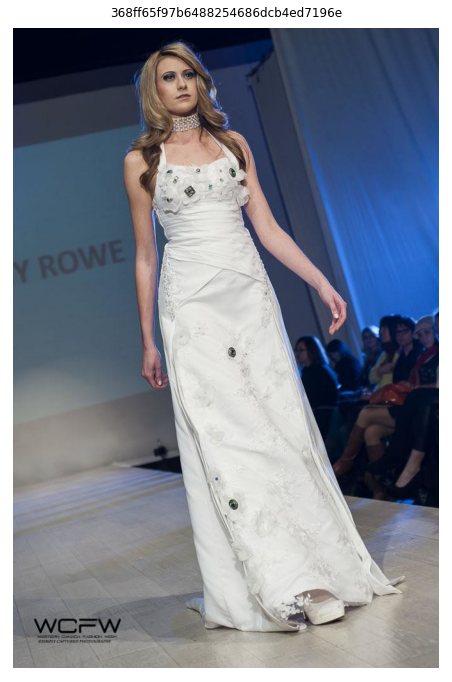


*** No instances to display *** 



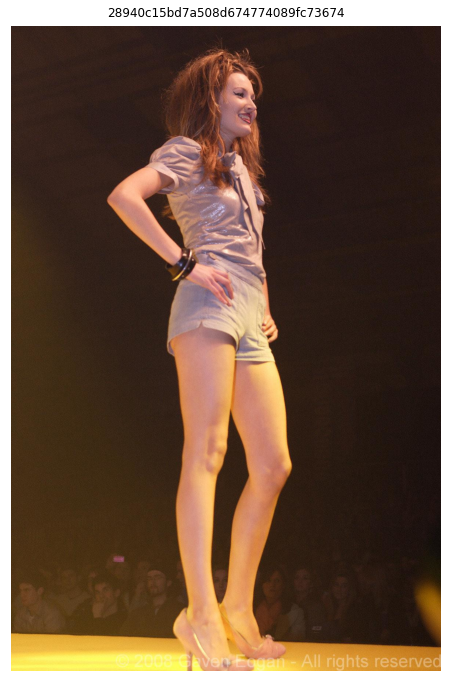


*** No instances to display *** 



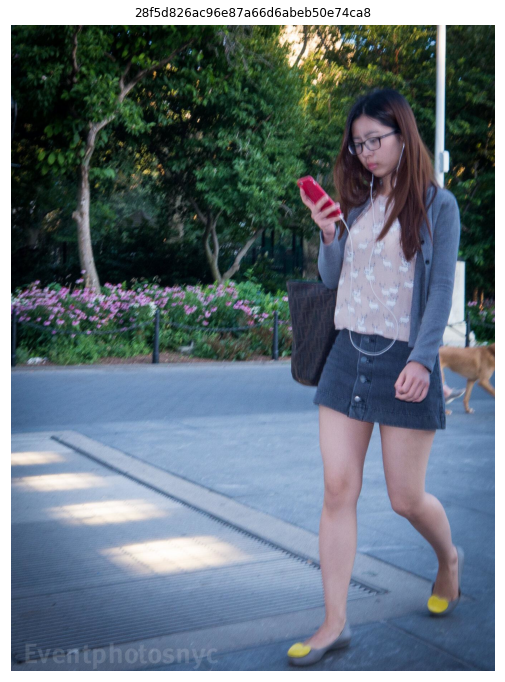


*** No instances to display *** 



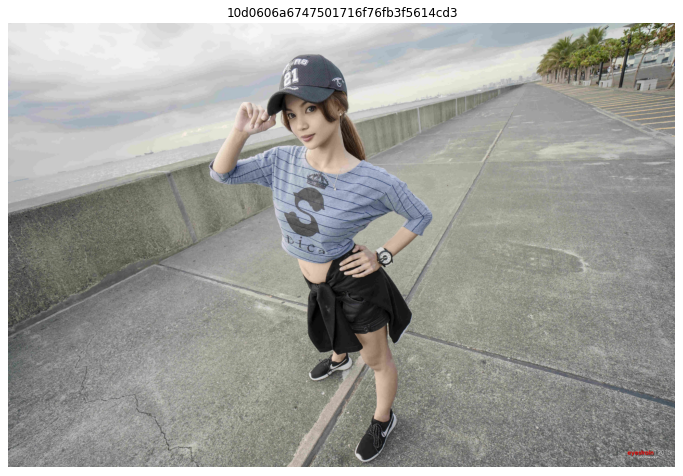


*** No instances to display *** 



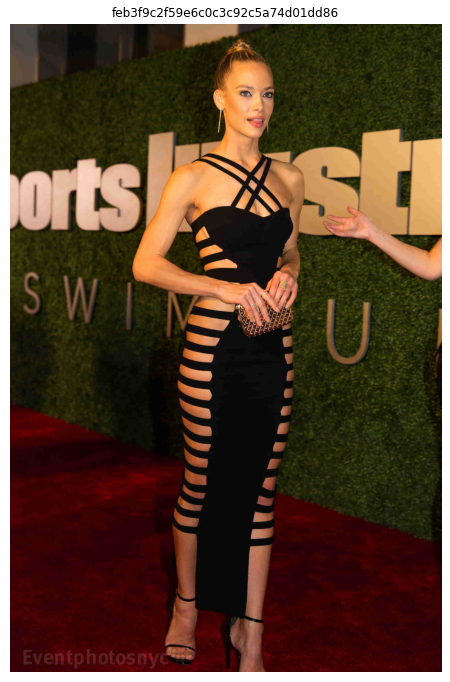


*** No instances to display *** 



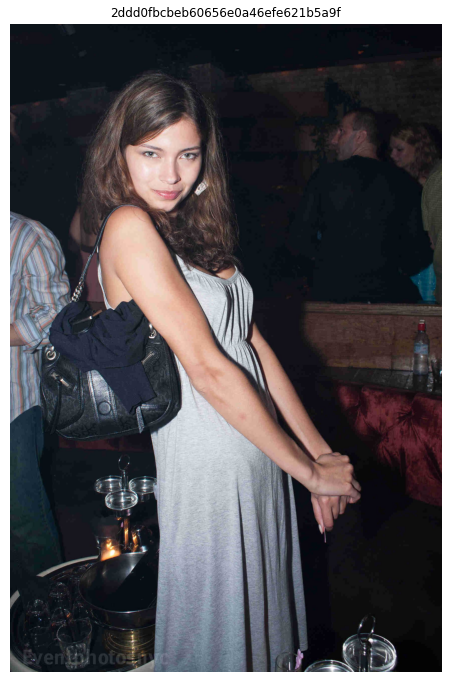


*** No instances to display *** 



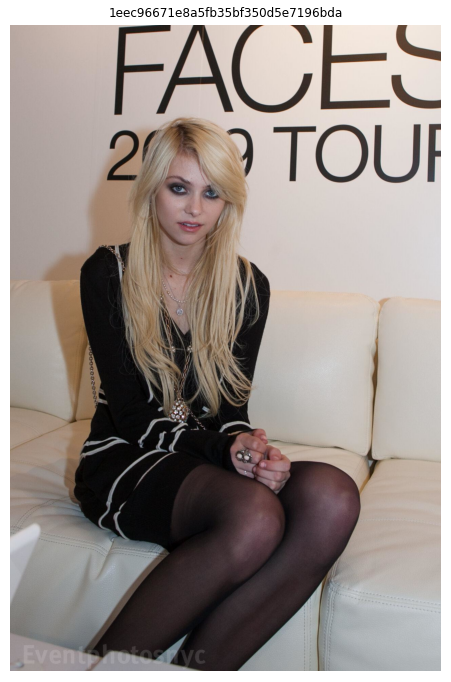


*** No instances to display *** 



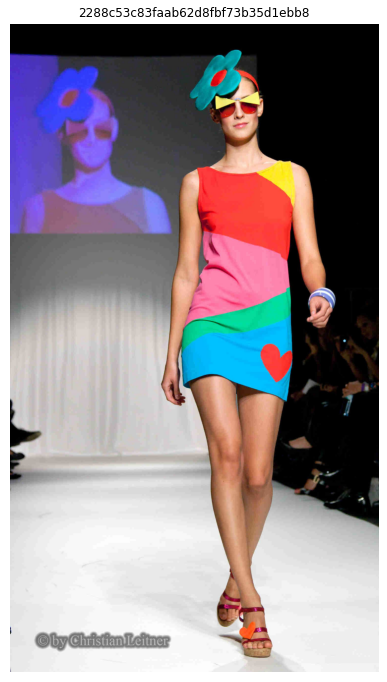


*** No instances to display *** 



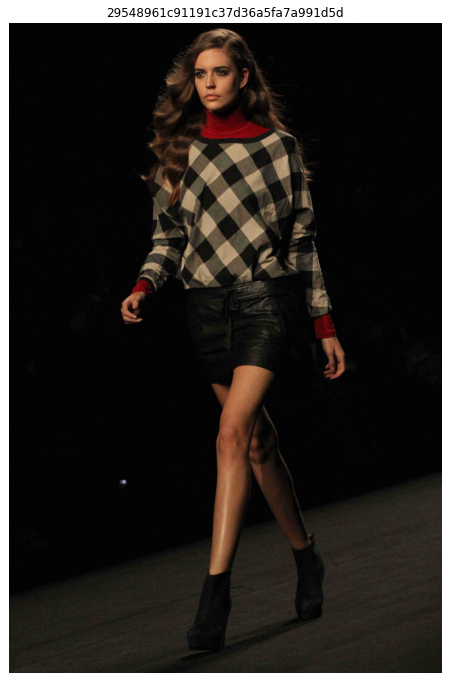

In [65]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
#     image_path = str(DATA_DIR/'test'/image_id)
    image_path = fr'{DATA_DIR}/test/{image_id}.jpg'
#     print(image_id)
#     print(image_path)
    
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'],fashion_data.class_names,
                                 r['scores'],
                                title=image_id, figsize=(12, 12))

## Evaluation

In [66]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(valid_fashion_data.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(valid_fashion_data, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

KeyboardInterrupt: 